##### Copyright 2019 The TensorFlow Authors.

In [117]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [118]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [119]:
#!/usr/bin/env python3
# SPDX-License-Identifier: BSD-2-Clause
# Copyright (c) 2018 Jakub Červený


def gilbert2d(width, height):
    """
    Generalized Hilbert ('gilbert') space-filling curve for arbitrary-sized
    2D rectangular grids. Generates discrete 2D coordinates to fill a rectangle
    of size (width x height).
    """

    if width >= height:
        yield from generate2d(0, 0, width, 0, 0, height)
    else:
        yield from generate2d(0, 0, 0, height, width, 0)


def sgn(x):
    return -1 if x < 0 else (1 if x > 0 else 0)


def generate2d(x, y, ax, ay, bx, by):

    w = abs(ax + ay)
    h = abs(bx + by)

    (dax, day) = (sgn(ax), sgn(ay)) # unit major direction
    (dbx, dby) = (sgn(bx), sgn(by)) # unit orthogonal direction

    if h == 1:
        # trivial row fill
        for i in range(0, w):
            yield(x, y)
            (x, y) = (x + dax, y + day)
        return

    if w == 1:
        # trivial column fill
        for i in range(0, h):
            yield(x, y)
            (x, y) = (x + dbx, y + dby)
        return

    (ax2, ay2) = (ax//2, ay//2)
    (bx2, by2) = (bx//2, by//2)

    w2 = abs(ax2 + ay2)
    h2 = abs(bx2 + by2)

    if 2*w > 3*h:
        if (w2 % 2) and (w > 2):
            # prefer even steps
            (ax2, ay2) = (ax2 + dax, ay2 + day)

        # long case: split in two parts only
        yield from generate2d(x, y, ax2, ay2, bx, by)
        yield from generate2d(x+ax2, y+ay2, ax-ax2, ay-ay2, bx, by)

    else:
        if (h2 % 2) and (h > 2):
            # prefer even steps
            (bx2, by2) = (bx2 + dbx, by2 + dby)

        # standard case: one step up, one long horizontal, one step down
        yield from generate2d(x, y, bx2, by2, ax2, ay2)
        yield from generate2d(x+bx2, y+by2, ax, ay, bx-bx2, by-by2)
        yield from generate2d(x+(ax-dax)+(bx2-dbx), y+(ay-day)+(by2-dby),
                              -bx2, -by2, -(ax-ax2), -(ay-ay2))


In [120]:
#!/usr/bin/env python3
# SPDX-License-Identifier: BSD-2-Clause
# Copyright (c) 2018 Jakub Červený


def gilbert3d(width, height, depth):
    """
    Generalized Hilbert ('Gilbert') space-filling curve for arbitrary-sized
    3D rectangular grids. Generates discrete 3D coordinates to fill a cuboid
    of size (width x height x depth). Even sizes are recommended in 3D.
    """

    if width >= height and width >= depth:
       yield from generate3d(0, 0, 0,
                             width, 0, 0,
                             0, height, 0,
                             0, 0, depth)

    elif height >= width and height >= depth:
       yield from generate3d(0, 0, 0,
                             0, height, 0,
                             width, 0, 0,
                             0, 0, depth)

    else: # depth >= width and depth >= height
       yield from generate3d(0, 0, 0,
                             0, 0, depth,
                             width, 0, 0,
                             0, height, 0)


def sgn(x):
    return -1 if x < 0 else (1 if x > 0 else 0)


def generate3d(x, y, z,
               ax, ay, az,
               bx, by, bz,
               cx, cy, cz):

    w = abs(ax + ay + az)
    h = abs(bx + by + bz)
    d = abs(cx + cy + cz)

    (dax, day, daz) = (sgn(ax), sgn(ay), sgn(az)) # unit major direction ("right")
    (dbx, dby, dbz) = (sgn(bx), sgn(by), sgn(bz)) # unit ortho direction ("forward")
    (dcx, dcy, dcz) = (sgn(cx), sgn(cy), sgn(cz)) # unit ortho direction ("up")

    # trivial row/column fills
    if h == 1 and d == 1:
        for i in range(0, w):
            yield(x, y, z)
            (x, y, z) = (x + dax, y + day, z + daz)
        return

    if w == 1 and d == 1:
        for i in range(0, h):
            yield(x, y, z)
            (x, y, z) = (x + dbx, y + dby, z + dbz)
        return

    if w == 1 and h == 1:
        for i in range(0, d):
            yield(x, y, z)
            (x, y, z) = (x + dcx, y + dcy, z + dcz)
        return

    (ax2, ay2, az2) = (ax//2, ay//2, az//2)
    (bx2, by2, bz2) = (bx//2, by//2, bz//2)
    (cx2, cy2, cz2) = (cx//2, cy//2, cz//2)

    w2 = abs(ax2 + ay2 + az2)
    h2 = abs(bx2 + by2 + bz2)
    d2 = abs(cx2 + cy2 + cz2)

    # prefer even steps
    if (w2 % 2) and (w > 2):
       (ax2, ay2, az2) = (ax2 + dax, ay2 + day, az2 + daz)

    if (h2 % 2) and (h > 2):
       (bx2, by2, bz2) = (bx2 + dbx, by2 + dby, bz2 + dbz)

    if (d2 % 2) and (d > 2):
       (cx2, cy2, cz2) = (cx2 + dcx, cy2 + dcy, cz2 + dcz)

    # wide case, split in w only
    if (2*w > 3*h) and (2*w > 3*d):
       yield from generate3d(x, y, z,
                             ax2, ay2, az2,
                             bx, by, bz,
                             cx, cy, cz)

       yield from generate3d(x+ax2, y+ay2, z+az2,
                             ax-ax2, ay-ay2, az-az2,
                             bx, by, bz,
                             cx, cy, cz)

    # do not split in d
    elif 3*h > 4*d:
       yield from generate3d(x, y, z,
                             bx2, by2, bz2,
                             cx, cy, cz,
                             ax2, ay2, az2)

       yield from generate3d(x+bx2, y+by2, z+bz2,
                             ax, ay, az,
                             bx-bx2, by-by2, bz-bz2,
                             cx, cy, cz)

       yield from generate3d(x+(ax-dax)+(bx2-dbx),
                             y+(ay-day)+(by2-dby),
                             z+(az-daz)+(bz2-dbz),
                             -bx2, -by2, -bz2,
                             cx, cy, cz,
                             -(ax-ax2), -(ay-ay2), -(az-az2))

    # do not split in h
    elif 3*d > 4*h:
       yield from generate3d(x, y, z,
                             cx2, cy2, cz2,
                             ax2, ay2, az2,
                             bx, by, bz)

       yield from generate3d(x+cx2, y+cy2, z+cz2,
                             ax, ay, az,
                             bx, by, bz,
                             cx-cx2, cy-cy2, cz-cz2)

       yield from generate3d(x+(ax-dax)+(cx2-dcx),
                             y+(ay-day)+(cy2-dcy),
                             z+(az-daz)+(cz2-dcz),
                             -cx2, -cy2, -cz2,
                             -(ax-ax2), -(ay-ay2), -(az-az2),
                             bx, by, bz)

    # regular case, split in all w/h/d
    else:
       yield from generate3d(x, y, z,
                             bx2, by2, bz2,
                             cx2, cy2, cz2,
                             ax2, ay2, az2)

       yield from generate3d(x+bx2, y+by2, z+bz2,
                             cx, cy, cz,
                             ax2, ay2, az2,
                             bx-bx2, by-by2, bz-bz2)

       yield from generate3d(x+(bx2-dbx)+(cx-dcx),
                             y+(by2-dby)+(cy-dcy),
                             z+(bz2-dbz)+(cz-dcz),
                             ax, ay, az,
                             -bx2, -by2, -bz2,
                             -(cx-cx2), -(cy-cy2), -(cz-cz2))

       yield from generate3d(x+(ax-dax)+bx2+(cx-dcx),
                             y+(ay-day)+by2+(cy-dcy),
                             z+(az-daz)+bz2+(cz-dcz),
                             -cx, -cy, -cz,
                             -(ax-ax2), -(ay-ay2), -(az-az2),
                             bx-bx2, by-by2, bz-bz2)

       yield from generate3d(x+(ax-dax)+(bx2-dbx),
                             y+(ay-day)+(by2-dby),
                             z+(az-daz)+(bz2-dbz),
                             -bx2, -by2, -bz2,
                             cx2, cy2, cz2,
                             -(ax-ax2), -(ay-ay2), -(az-az2))


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [130]:
#first see if the train and test images are already created
try:
    train_images = np.load('train_images.npy')
    test_images = np.load('test_images.npy')
except:
    train_images = None
    test_images = None

if train_images is not None and test_images is not None:
    print('Train and test images already created')
    print(train_images.shape)
    print(test_images.shape)
    exit()
    

(train_images_orig, train_labels), (test_images_orig, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images_orig, test_images_orig = train_images_orig / 255.0, test_images_orig / 255.0

#Create the 3d gilbert curve

#Create the train and test images with the original shapes

#NEXT EXPAND THE IMAGES TO 32X32X6 - The originals plus the hilbert modified images

train_images = np.zeros((train_images_orig.shape[0], 32,32,6))
test_images = np.zeros((test_images_orig.shape[0], 32,32,6))

gilbert_curve = list(gilbert2d(32, 32))

#loop through first index of train_images_orig


for i in range(train_images_orig.shape[0]):
    
    #index through the images starting from bottom left
    a,b = 0,0
    #loop through the gilbert curve
    for j, (x, y) in enumerate(gilbert_curve):
        #set the pixel value of the train_images to the pixel value of the train_images_orig
        train_images[i][x][y][0] = train_images_orig[i][a][b][0]
        train_images[i][x][y][1] = train_images_orig[i][a][b][1]
        train_images[i][x][y][2] = train_images_orig[i][a][b][2]
        train_images[i][x][y][3] = train_images_orig[i][x][y][0]
        train_images[i][x][y][4] = train_images_orig[i][x][y][1]
        train_images[i][x][y][5] = train_images_orig[i][x][y][2]
        #increment the index of the train_images_orig
        b += 1
        if b == 32:
            a += 1
            b = 0

for i in range(test_images_orig.shape[0]):
    #index through the images starting from bottom left
    a,b = 0,0
    #loop through the gilbert curve
    for j, (x, y) in enumerate(gilbert_curve):
        #set the pixel value of the train_images to the pixel value of the train_images_orig
        test_images[i][x][y][0] = test_images_orig[i][a][b][0]
        test_images[i][x][y][1] = test_images_orig[i][a][b][1]
        test_images[i][x][y][2] = test_images_orig[i][a][b][2]
        test_images[i][x][y][3] = test_images_orig[i][x][y][0]
        test_images[i][x][y][4] = test_images_orig[i][x][y][1]
        test_images[i][x][y][5] = test_images_orig[i][x][y][2]
        #increment the index of the train_images_orig
        b += 1
        if b == 32:
            a += 1
            b = 0


#save the train and test images
np.save('train_images.npy', train_images)
np.save('test_images.npy', test_images)





### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


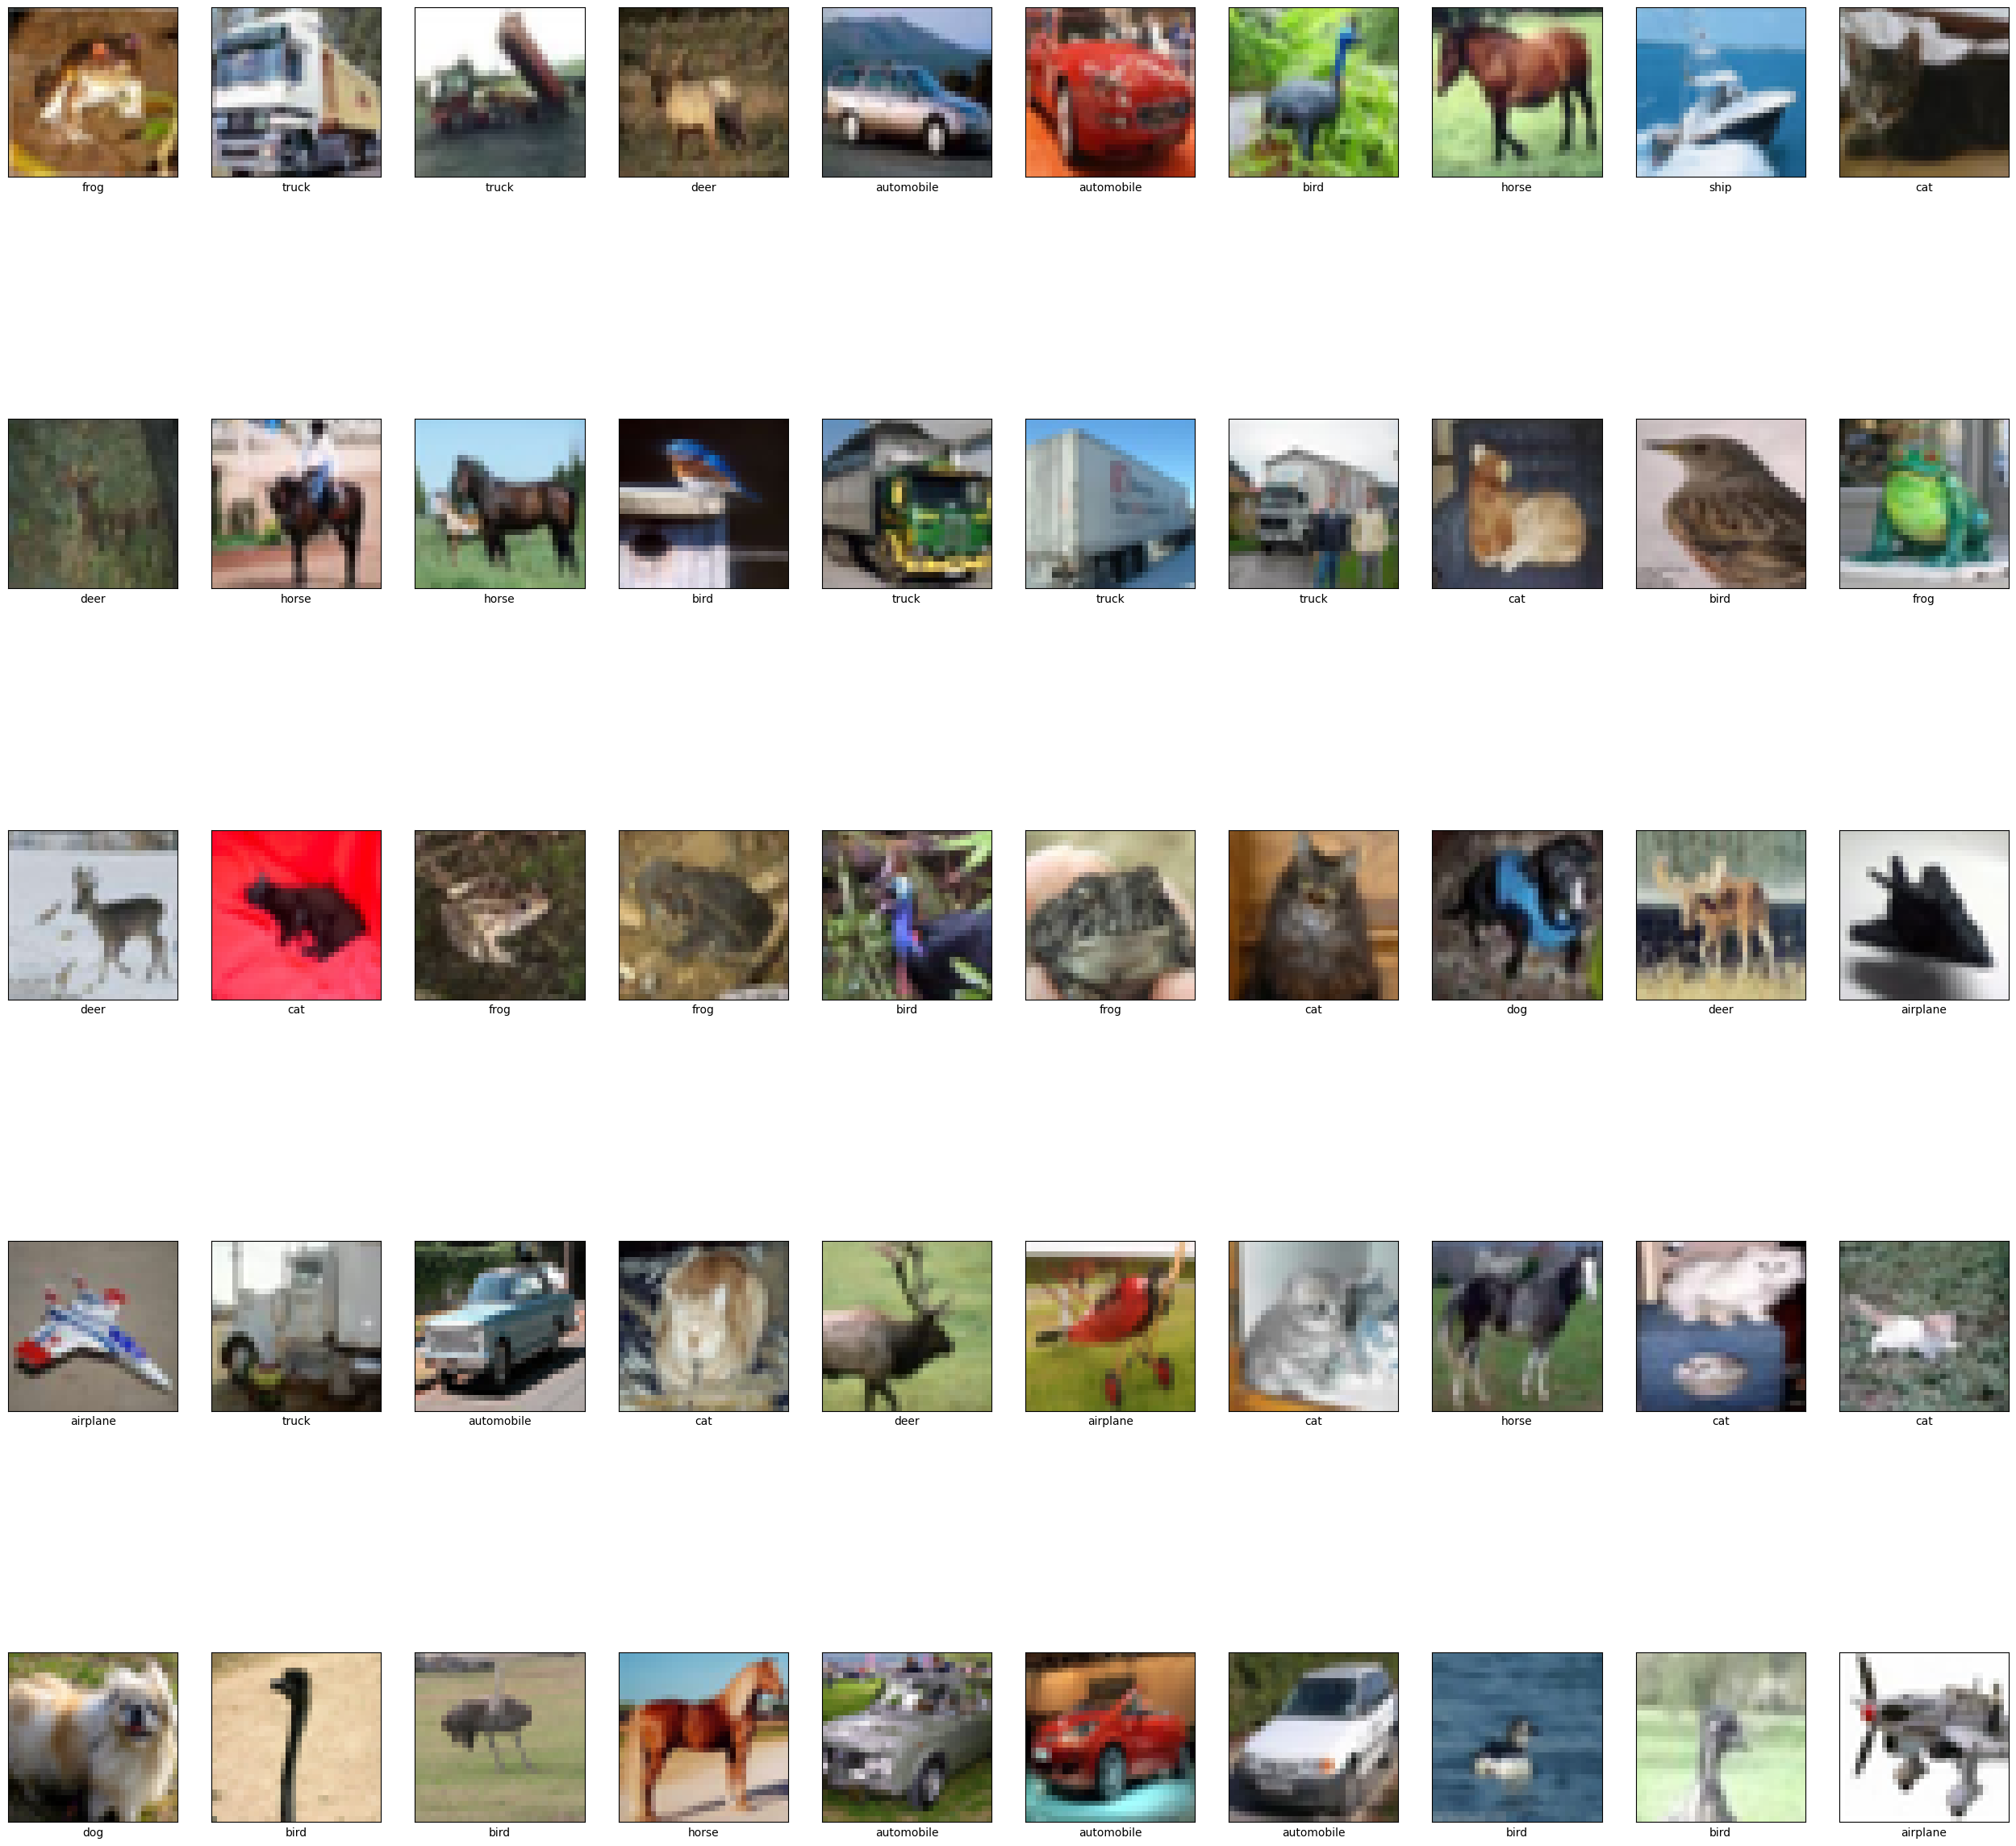

In [122]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(32,32))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_orig[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [123]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 6)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))


Let's display the architecture of your model so far:

In [124]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 30, 30, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 256)    │       147,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,968 (656.12 KB)

 Trainable params: 167,968 (656.12 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [125]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [126]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 30, 30, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,527,978 (9.64 MB)

 Trainable params: 2,527,978 (9.64 MB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, batch_size=100, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3374 - loss: 1.9199 - val_accuracy: 0.5354 - val_loss: 1.3149
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5765 - loss: 1.2255 - val_accuracy: 0.6101 - val_loss: 1.1489
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6308 - loss: 1.0647 - val_accuracy: 0.6264 - val_loss: 1.0746
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6483 - loss: 1.0194 - val_accuracy: 0.6144 - val_loss: 1.0939
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6544 - loss: 0.9896 - val_accuracy: 0.6005 - val_loss: 1.1551
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6590 - loss: 0.9948 - val_accuracy: 0.5992 - val_loss: 1.1545
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6443 - loss: 1.0181 - val_accuracy: 0.5787 - val_loss: 1.2152
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6316 - loss: 1.0576 - val_acc

### Evaluate the model

313/313 - 2s - 6ms/step - accuracy: 0.6035 - loss: 1.1513


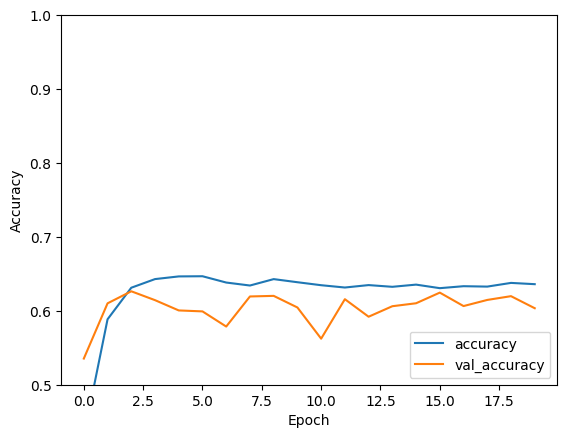

In [128]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [129]:
print(test_acc)

0.6035000085830688


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.